In [230]:
import requests
from requests_html import HTMLSession
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options  
from itertools import chain
from functools import reduce
import pandas as pd
import numpy as np
import time
import re
import random
from lxml import html
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
#Use Chrome Driver & login in to instagram
driver = webdriver.Chrome()
driver.implicitly_wait(1)
driver.get('https://www.barttorvik.com/playerstat.php?link=y&year=2019&start=20181101&end=20190501')

In [374]:
#Use Chrome Driver & login in to instagram
driver = webdriver.Chrome()
driver.implicitly_wait(1)
driver.get('https://www.nba.com/stats/draft/combine-anthro/?SeasonYear=2018-19')

In [451]:
###Helper Functions
def create_driver(**kwargs):
    
    headless = kwargs.get('headless')
    
    chrome_options = Options() 
    
    if headless:
        chrome_options.add_argument("--headless") 
        
    driver = webdriver.Chrome(options=chrome_options)
    
    return driver

def get_elements_text(element_list):
    
    return [e.text for e in element_list]

def dict_to_df(**kwargs):
    
    col_dict = kwargs.get('col_dict')
    
    if 'df' in kwargs:
        df = kwargs.get('df')
    else:
        df = pd.DataFrame()
    
    for key, value in col_dict.items():       
        df[key] = value
    
    return(df)

def expand_table(**kwargs):
    
    driver=kwargs.get('driver')
    timeout=kwargs.get('timeout')
    max_records=kwargs.get('max_records')
    
    start_time = datetime.now()
    page_done = False
    curr_records = 50
    
    while not page_done:
        
        time_elapsed = (datetime.now() - start_time).seconds
        if time_elapsed >= timeout or curr_records >= max_records:
            break
            
        try:
            expand_button = driver.find_element_by_css_selector("#expand") 
            expand_button.click()
            curr_records = curr_records + 100
        except Exception as e:
            page_done = True
    
    return driver

###Functions
#Scrape data

def get_college_url(**kwargs):
    
    driver = kwargs.get('driver')
    season = kwargs.get('season')
    
    if season is None or 'season' not in kwargs:
        raise Exception("Please enter a valid season!")
        
    #Format string to create url
    season_start = season
    season_end = season_start + 1
        
    url = 'https://www.barttorvik.com/playerstat.php?link=y&year=%s&start=%s1101&end=%s0501'%(season_end,season_start,season_end)
    
    #Go to combine url
    driver.get(url)
    time.sleep(1)
    
    return(driver)

def get_combine_url(**kwargs):
    
    driver = kwargs.get('driver')
    season = kwargs.get('season')
    combine_type = kwargs.get('combine_type')
    
    if season is None or 'season' not in kwargs:
        raise Exception("Please enter a valid season!")
        
    if combine_type == 'anthro':
        c_type = 'anthro'
    elif combine_type == 'strength':
        c_type = 'strength-agility'
    else:
        raise Exception("Please enter a valid combine type. Options: anthro, strength")
        
    #Format string to create url
    season_start = season
    season_end = str(season_start + 1)[-2:]
    url = 'https://www.nba.com/stats/draft/combine-%s/?SeasonYear=%s-%s'%(c_type,season_start,season_end)
    
    #Go to combine url
    driver.get(url)
    time.sleep(1)
    
    return(driver)

def get_season_page(**kwargs):
    
    season = kwargs.get('season')
    agg_type = kwargs.get('agg_type')
    
    if season is None or 'season' not in kwargs:
        raise Exception("Please enter a valid season!")
    
    season = season + 1
    
    if agg_type == 'game':
        a_type = 'game'
    elif agg_type == '36min':
        a_type = 'minute'
    elif agg_type == '100p':
        a_type = 'poss'
    else:
        raise Exception("Please enter a valid combine type. Options: game, 36min, 100p")
        
        
    url = 'https://www.basketball-reference.com/leagues/NBA_%s_per_%s.html'%(season,agg_type)
    page = requests.get(url)
    tree = html.fromstring(page.content)
    
    return tree

def get_combine_info(**kwargs):
    
    driver = kwargs.get('driver')
    wait = WebDriverWait(driver, 10)

    combine_elements = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'td')))
    combine_info = [ai.text for ai in combine_elements]
    combine_info_clean = combine_info[:combine_info[1:].index(combine_info[0])]
    
    return driver, combine_info_clean
    
def get_combine_anthro_df(driver,combine_info_clean):
    
    wait = WebDriverWait(driver, 10)
    last_elements = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'td:nth-child(10)')))
    last_element = last_elements[-1]
    
    alc = combine_info_clean
    lt = last_element.text
    anthro_info_list = [{'name':alc[i*10],'position':alc[i*10+1],'body_fat':alc[i*10+2],'hand_length':alc[i*10+3],'hand_width':alc[i*10+4],'height_noshoes':alc[i*10+5],'height_shoes':alc[i*10+6],'reach':alc[i*10+7],'weight':alc[i*10+8],'wingspan':alc[i*10+9]} if i < int(len(alc)/10) else {'name':alc[i*10],'position':alc[i*10+1],'body_fat':alc[i*10+2],'hand_length':alc[i*10+3],'hand_width':alc[i*10+4],'height_noshoes':alc[i*10+5],'height_shoes':alc[i*10+6],'reach':alc[i*10+7],'weight':alc[i*10+8],'wingspan':lt} for i in range(int(len(alc)/10)+1)]
    anthro_info_df = pd.DataFrame(anthro_info_list)
    
    return driver, anthro_info_df

def get_combine_strength_df(combine_info_clean):
    
    alc = combine_info_clean
    strength_info_list = [{'name':alc[i*8],'position':alc[i*8+1],'lane_agility':alc[i*8+2],'shuttle':alc[i*8+3],'3q_sprint':alc[i*8+4],'standing_vert':alc[i*8+5],'max_vert':alc[i*8+6],'max_bench':alc[i*8+7]} for i in range(int(len(alc)/8))]
    strength_info_df = pd.DataFrame(strength_info_list)
    
    return strength_info_df

def get_stats_elements(**kwargs):
    
    driver = kwargs.get('driver')
    wait = WebDriverWait(driver, 10)
    
    player_elements = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'a')))
    player_info_list = [pe.text for pe in player_elements]
    player_info_clean = player_info_list[player_info_list.index('Reset')+1:player_info_list.index('SHOW 100 MORE')]
    player_info_list = [{'name':player_info_clean[i*4],'college':player_info_clean[i*4+1],'conference':player_info_clean[i*4+2]} for i in range(int(len(player_info_clean)/4))]
    player_info_df = pd.DataFrame(player_info_list)
    
    pprgi_e = driver.find_elements_by_css_selector("._28")
    bpm_e = driver.find_elements_by_css_selector("._53")
    ortg_e = driver.find_elements_by_css_selector("._5")
    usg_e = driver.find_elements_by_css_selector("._6")
    efg_e = driver.find_elements_by_css_selector("._7")
    ts_e = driver.find_elements_by_css_selector("._8")
    orb_e = driver.find_elements_by_css_selector("._9")
    drb_e = driver.find_elements_by_css_selector("._10")
    ast_e = driver.find_elements_by_css_selector("._11")
    to_e = driver.find_elements_by_css_selector("._12")
    blk_e = driver.find_elements_by_css_selector("._10")
    stl_e = driver.find_elements_by_css_selector("._11")
    ftr_e = driver.find_elements_by_css_selector("._12")
    two_p_e = driver.find_elements_by_css_selector("._1617")
    three_100_e = driver.find_elements_by_css_selector("._65")
    three_p_e = driver.find_elements_by_css_selector("._1920")
    
    elements_dict = {'name':player_info_df['name']
                    ,'college':player_info_df['college']
                    ,'conference':player_info_df['conference']
                    ,'pprgi_e':pprgi_e
                    ,'bpm_e':bpm_e
                    ,'ortg_e':ortg_e
                    ,'usg_e':usg_e
                    ,'efg_e':efg_e
                    ,'ts_e':ts_e
                    ,'orb_e':orb_e
                    ,'drb_e':drb_e
                    ,'ast_e':ast_e
                    ,'to_e':to_e
                    ,'blk_e':blk_e
                    ,'stl_e':stl_e
                    ,'ftr_e':ftr_e
                    ,'two_p_e':two_p_e
                    ,'three_100_e':three_100_e
                    ,'three_p_e':three_p_e}
    
    return elements_dict 

#Convert to text
def get_stats_text(**kwargs):

    elements_dict = kwargs.get('elements_dict')
    
    name = elements_dict['name']
    college = elements_dict['college']
    conference = elements_dict['conference']
    pprgi = get_elements_text(elements_dict['pprgi_e'])
    bpm = get_elements_text(elements_dict['bpm_e'])
    ortg = get_elements_text(elements_dict['ortg_e'])
    usg = get_elements_text(elements_dict['usg_e'])
    efg = get_elements_text(elements_dict['efg_e'])
    ts = get_elements_text(elements_dict['ts_e'])
    orb = get_elements_text(elements_dict['orb_e'])
    drb = get_elements_text(elements_dict['drb_e'])
    ast = get_elements_text(elements_dict['ast_e'])
    to = get_elements_text(elements_dict['to_e'])
    blk = get_elements_text(elements_dict['blk_e'])
    stl = get_elements_text(elements_dict['stl_e'])
    ftr = get_elements_text(elements_dict['ftr_e'])
    two_p = get_elements_text(elements_dict['two_p_e'])
    three_100 = get_elements_text(elements_dict['three_100_e'])
    three_p = get_elements_text(elements_dict['three_p_e'])
    two_pm = [p.split('-')[0] for p in two_p]
    two_pa = [p.split('-')[1] for p in two_p]
    three_pm = [p.split('-')[0] for p in three_p]
    three_pa = [p.split('-')[1] for p in three_p]
    
    stats_dict = {'name':name
                ,'college':college
                ,'conference':conference
                ,'pprgi':pprgi
                ,'bpm':bpm
                ,'ortg':ortg
                ,'usg':usg
                ,'efg':efg
                ,'ts':ts
                ,'orb':orb
                ,'drb':drb
                ,'ast':ast
                ,'to':to
                ,'blk':blk
                ,'stl':stl
                ,'ftr':ftr
                ,'two_pa':two_pa
                ,'two_pm':two_pm
                ,'2pt_pct':pd.Series(two_pm,dtype=np.int32)/pd.Series(two_pa,dtype=np.int32)
                ,'three_100':three_100
                ,'three_pa':three_pa
                ,'three_pm':three_pm
                ,'3pt_pct':pd.Series(three_pm,dtype=np.int32)/pd.Series(three_pa,dtype=np.int32)}
    
    return stats_dict

###Final Functions to get data
def get_college_stats_df(**kwargs):
    
    season = kwargs.get('season')
    
    driver = create_driver(headless=True)
    driver = get_college_url(driver=driver,season=season)
    driver = expand_table(driver=driver,timeout=10,max_records=500)
    elements_dict = get_stats_elements(driver=driver)
    stats_dict = get_stats_text(elements_dict=elements_dict)
    yearly_stats_df = dict_to_df(col_dict=stats_dict)
    
    return yearly_stats_df

def get_combine_anthro_stats_df(**kwargs):
    
    season = kwargs.get('season')
    
    driver = create_driver(headless=False)
    driver = get_combine_url(driver=driver,season=season,combine_type='anthro')
    driver, combine_info_clean = get_combine_info(driver=driver)
    driver, anthro_info_df = get_combine_anthro_df(driver, combine_info_clean)
    driver.quit()
    
    return anthro_info_df

def get_combine_strength_stats_df(**kwargs):
    
    season = kwargs.get('season')
    
    driver = create_driver(headless=False)
    driver = get_combine_url(driver=driver,season=season,combine_type='strength')
    driver, combine_info_clean = get_combine_info(driver=driver)
    strength_info_df = get_combine_strength_df(combine_info_clean)
    driver.quit()
    
    return strength_info_df

def get_combine_full_df(**kwargs):
    
    season = kwargs.get('season')
    
    anthro_info_df = get_combine_anthro_stats_df(season=season)
    strength_info_df = get_combine_strength_stats_df(season=season)
    combined_df = anthro_info_df.join(strength_info_df.set_index(['name','position']),on=['name','position'])
    
    return combined_df

def get_season_df(tree):
    
    name = tree.xpath('//tr[@class="full_table"]//td[@data-stat="player"]//text()')
    pos = tree.xpath('//tr[@class="full_table"]//td[@data-stat="pos"]//text()')
    age = tree.xpath('//tr[@class="full_table"]//td[@data-stat="pos"]//text()')
    fgm = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg_per_%s"]//text()'%agg_type)
    fga = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fga_per_%s"]//text()'%agg_type)
    fg_pct_e = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg_pct"]')
    fg_pct = [fg.text for fg in fg_pct_e]
    fg3m = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg3_per_%s"]//text()'%agg_type)
    fg3a = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg3a_per_%s"]//text()'%agg_type)
    fg3_pct_e = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg3_pct"]')
    fg3_pct = [fg.text for fg in fg3_pct_e]
    fg2m = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg2_per_%s"]//text()'%agg_type)
    fg2a = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg2a_per_%s"]//text()'%agg_type)
    fg2_pct_e = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fg2_pct"]')
    fg2_pct = [fg.text for fg in fg2_pct_e]
    ftm = tree.xpath('//tr[@class="full_table"]//td[@data-stat="ft_per_%s"]//text()'%agg_type)
    fta = tree.xpath('//tr[@class="full_table"]//td[@data-stat="fta_per_%s"]//text()'%agg_type)
    ft_pct_e = tree.xpath('//tr[@class="full_table"]//td[@data-stat="ft_pct"]')
    ft_pct = [ft.text for ft in ft_pct_e]
    orb = tree.xpath('//tr[@class="full_table"]//td[@data-stat="orb_per_%s"]//text()'%agg_type)
    drb = tree.xpath('//tr[@class="full_table"]//td[@data-stat="drb_per_%s"]//text()'%agg_type)
    trb = tree.xpath('//tr[@class="full_table"]//td[@data-stat="trb_per_%s"]//text()'%agg_type)
    ast = tree.xpath('//tr[@class="full_table"]//td[@data-stat="ast_per_%s"]//text()'%agg_type)
    stl = tree.xpath('//tr[@class="full_table"]//td[@data-stat="stl_per_%s"]//text()'%agg_type)
    blk = tree.xpath('//tr[@class="full_table"]//td[@data-stat="blk_per_%s"]//text()'%agg_type)
    pts = tree.xpath('//tr[@class="full_table"]//td[@data-stat="pts_per_%s"]//text()'%agg_type)
    efg_pct_e = tree.xpath('//tr[@class="full_table"]//td[@data-stat="efg_pct"]')
    efg_pct = [fg.text for fg in efg_pct_e]
    
    season_stats_df = pd.DataFrame({'name':name
                                ,'pos':pos
                                ,'age':age
                                ,'fgm':fgm
                                ,'fga':fga
                                ,'fg_pct':fg_pct
                                ,'fg3m':fg3m
                                ,'fg3a':fg3a
                                ,'fg3_pct':fg3_pct
                                ,'fg2m':fg2m
                                ,'fg2a':fg2a
                                ,'fg2_pct':fg2_pct
                                ,'ftm':ftm
                                ,'fta':fta
                                ,'ft_pct':ft_pct
                                ,'orb':orb
                                ,'drb':drb
                                ,'trb':trb
                                ,'ast':ast
                                ,'stl':stl
                                ,'blk':blk
                                ,'pts':pts
                                ,'efg_pct':efg_pct})

    return season_stats_df

def get_season_stats_df(**kwargs):
    
    season = kwargs.get('season')
    agg_type = kwargs.get('agg_type')
    
    tree = get_season_page(season=season,agg_type=agg_type)
    season_df = get_season_df(tree)
    
    return season_df


def get_college_combine_season_df(**kwargs):
    
    draft = kwargs.get('draft')
    season = kwargs.get('season')
    
    college_df = get_college_stats_df(season=draft)
    combine_df = get_combine_full_df(season=draft+1)
    season_stats_df = get_season_stats_df(season=season,agg_type='game')

    college_combine_df = college_df.join(combine_df.set_index('name'),on='name')
    college_combine_season_df = college_combine_df.join(season_stats_df.set_index('name'),on='name',lsuffix='_c')
    college_combine_season_df.loc[:,'pprgi':'3pt_pct'] = college_combine_season_df.loc[:,'pprgi':'3pt_pct'].astype(np.float64)
    college_combine_season_df.loc[:,'fgm':'efg_pct'] = college_combine_season_df.loc[:,'fgm':'efg_pct'].astype(np.float64)
    
    return college_combine_season_df

def get_draft_df(**kwargs):
    
    draft = kwargs.get('draft')
    num_seasons = kwargs.get('num_seasons')
    
    for s in range(num_seasons):
        season = draft + s + 1
        college_combine_season_df = get_college_combine_season_df(draft=draft,season=season)
        college_combine_season_df['season'] = season
        if s == 0:
            draft_df = college_combine_season_df            
        else:
            draft_df = draft_df.append(college_combine_season_df)
            
    return draft_df

##Data Vizualisation Functions

def plot_correlation_map(**kwargs):
    
    df = kwargs.get('df')
    x_line_start = kwargs.get('x_line_start')
    x_line_end = kwargs.get('x_line_end')
    y_line_start = kwargs.get('y_line_start')
    y_line_end = kwargs.get('y_line_end')
    
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.tril(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    if x_line_start is not None:
        x_s = list(corr.columns.values).index(x_line_start)
        plt.vlines(x_s,0,100,colors='r')
    if x_line_end is not None:
        x_e = list(corr.columns.values).index(x_line_end)
        plt.vlines(x_e,0,100,colors='r')
    if y_line_start is not None:
        y_s = list(corr.columns.values).index(y_line_start)
        plt.hlines(y_s,0,100,colors='r')
    if y_line_end is not None:
        y_e = list(corr.columns.values).index(y_line_end)
        plt.hlines(y_e,0,100,colors='r')

    return corr

def add_lines(**kwargs):
    
    df = kwargs.get('df')
    
    x_line_start = kwargs.get('x_line_start')
    x_line_end = kwargs.get('x_line_end')
    y_line_start = kwargs.get('y_line_start')
    y_line_end = kwargs.get('y_line_end')
    
    if x_line_start is not None:
        x_s = list(df.columns.values).index(x_line_start)
        plt.vlines(x_s,0,100,colors='g')
    if x_line_end is not None:
        x_e = list(df.columns.values).index(x_line_end)
        plt.vlines(x_e,0,100,colors='g')
    if y_line_start is not None:
        y_s = list(df.columns.values).index(y_line_start)
        plt.hlines(y_s,0,100,colors='g')
    if y_line_end is not None:
        y_e = list(df.columns.values).index(y_line_end)
        plt.hlines(y_e,0,100,colors='g')
    
    return

In [446]:
draft_df_17 = get_draft_df(draft=2017,num_seasons=1)
draft_df_17.head()

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


,name,college,conference,pprgi,bpm,ortg,usg,efg,ts,orb_c,...,ft_pct,orb,drb,trb,ast,stl,blk,pts,efg_pct,season
0,Trae Young,Oklahoma,B12,7.1,10.2,112.1,38.4,51.9,58.6,1.3,...,0.829,0.8,2.9,3.7,8.1,0.9,0.2,19.1,0.480,2018
1,Jalen Brunson,Villanova,BE,6.4,9.5,128.5,26.1,60.4,63.5,1.2,...,0.725,0.3,2.0,2.3,3.2,0.5,0.1,9.3,0.523,2018
2,Jock Landale,Saint Mary's,WCC,6.3,8.3,125.7,30.1,64.4,66.8,12.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
3,Deandre Ayton,Arizona,P12,6.1,9.9,126.7,26.2,62.5,65.0,13.5,...,0.746,3.1,7.1,10.3,1.8,0.9,0.9,16.3,0.585,2018
4,Marvin Bagley III,Duke,ACC,6.1,9.6,123.8,25.8,64.0,64.3,13.8,...,0.691,2.6,5.0,7.6,1.0,0.5,1.0,14.9,0.525,2018


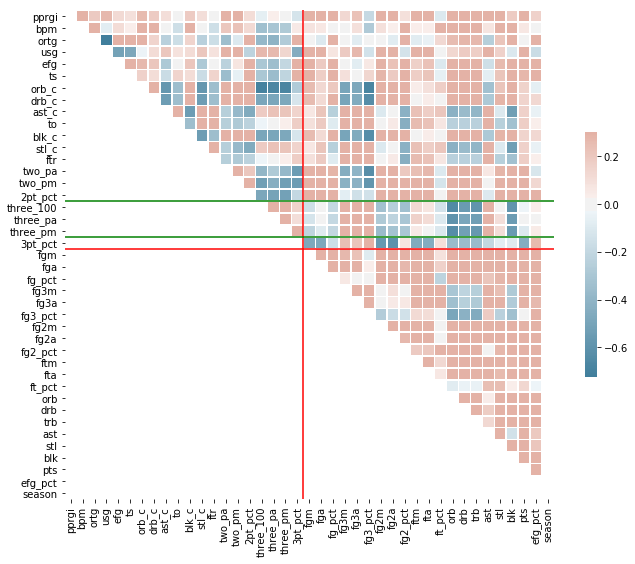

In [448]:
draft_df_18_s19 = draft_df_17.loc[draft_df_17['season']==2018,:]
corr = plot_correlation_map(df=draft_df_18_s19,x_line_start='fgm',y_line_start='fgm')
add_lines(df=corr, y_line_start='three_100',y_line_end='3pt_pct')

In [454]:
draft_df_15 = get_draft_df(draft=2015,num_seasons=4)
draft_df_16 = get_draft_df(draft=2016,num_seasons=3)
draft_df_17 = get_draft_df(draft=2017,num_seasons=2)
draft_df_18 = get_draft_df(draft=2018,num_seasons=1)

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2428: Futur

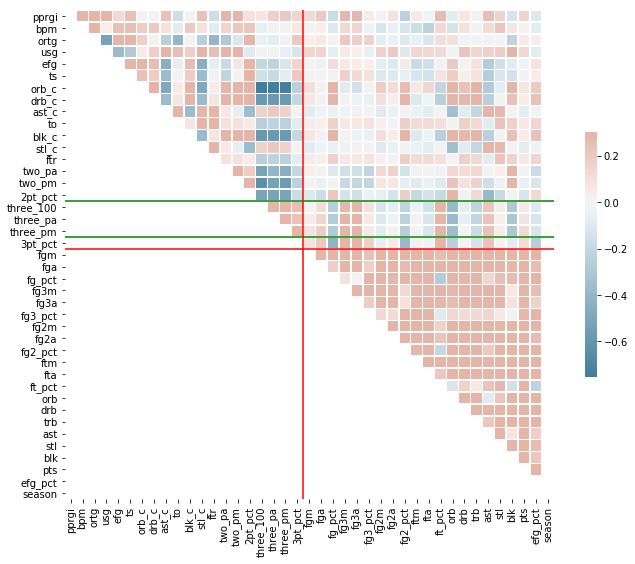

In [456]:
draft_df_15_s16 = draft_df_15.loc[draft_df_15['season']==2016,:]
corr = plot_correlation_map(df=draft_df_15_s16,x_line_start='fgm',y_line_start='fgm')
add_lines(df=corr, y_line_start='three_100',y_line_end='3pt_pct')

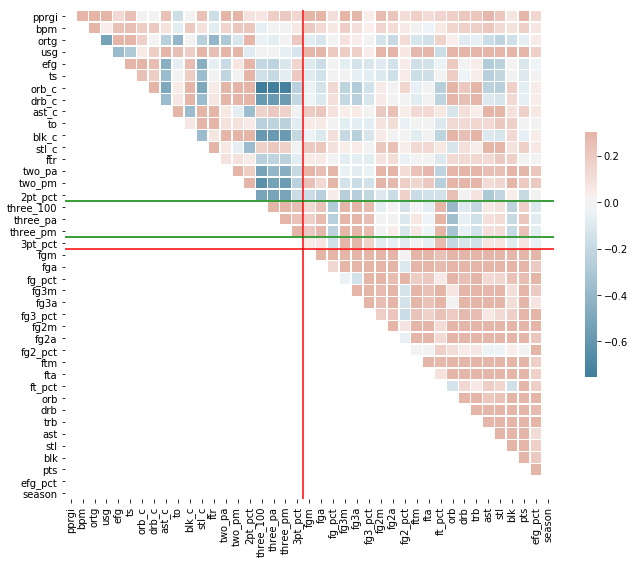

In [457]:
draft_df_15_s17 = draft_df_15.loc[draft_df_15['season']==2017,:]
corr = plot_correlation_map(df=draft_df_15_s17,x_line_start='fgm',y_line_start='fgm')
add_lines(df=corr, y_line_start='three_100',y_line_end='3pt_pct')

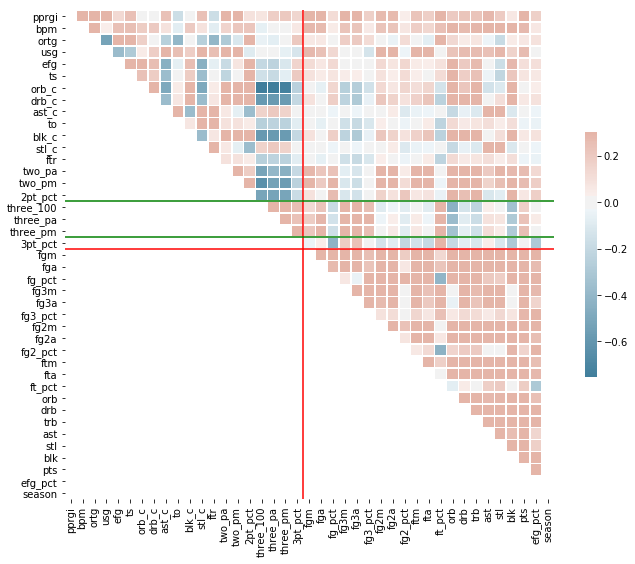

In [458]:
draft_df_15_s18 = draft_df_15.loc[draft_df_15['season']==2018,:]
corr = plot_correlation_map(df=draft_df_15_s18,x_line_start='fgm',y_line_start='fgm')
add_lines(df=corr, y_line_start='three_100',y_line_end='3pt_pct')